# Exercise 6. Text Clustering

In this exercise you will again analyse the Newsgroups dataset using clustering. We will do following steps:
1. Document preprocessing and representation
2. K-means clustering
3. LDA topic modelling

In [1]:
!pip install pyLDAvis

In [2]:
# Import packages
import pandas as pd
from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from gensim import corpora, models 
from pyLDAvis.gensim_models import prepare
import pickle 
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# 1. Document preprocessing and representation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, we will load the target classes, match them with the preprocessed data and derive the tf-idf document representation.

In [4]:
# Load targets
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# Load preprocessed texts
df['preprocessed']=pickle.load(open("/content/drive/MyDrive/TWSM_Data/Stemmed.pkl", "rb"))
# Focus on religion, hockey, mideast politics and motorcycles
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
df.head()

,content,target,target_names,preprocessed
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,recommend duc worth ducati gt line ducati gt m...
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,nhl team captain articl apr samba oit unc edu ...
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,pantheism environment articl apr atho rutger e...
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,isra expans lust articl spam math adelaid edu ...
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,goali mask articl netnew upenn edu kkeller mai...


In [5]:
# Initialise transformer
vec_tf=TfidfVectorizer(max_df=0.7, min_df=0.1)

In [6]:
# Apply the tfidf transformer
data_tfidf = vec_tf.fit_transform(df['preprocessed'])
print(data_tfidf.shape)

(2361, 90)


In [7]:
print(data_tfidf.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.16623354 0.1331325  0.         ... 0.         0.11734394 0.        ]
 [0.09078246 0.07270552 0.         ... 0.         0.06408316 0.        ]
 ...
 [0.02946274 0.04719203 0.12839892 ... 0.         0.02079769 0.        ]
 [0.1832043  0.04890799 0.         ... 0.         0.04310786 0.14014886]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [8]:
# Store the feature names
words = vec_tf.get_feature_names()
print(words)

['apr', 'articl', 'ask', 'awai', 'believ', 'best', 'better', 'bike', 'call', 'case', 'christian', 'claim', 'com', 'come', 'cours', 'dai', 'differ', 'dod', 'edu', 'end', 'exist', 'fact', 'far', 'follow', 'game', 'gener', 'get', 'go', 'god', 'good', 'got', 'great', 'happen', 'help', 'hockei', 'israel', 'kill', 'know', 'let', 'life', 'like', 'littl', 'live', 'long', 'look', 'lot', 'make', 'mean', 'need', 'new', 'opinion', 'peopl', 'person', 'place', 'plai', 'point', 'possibl', 'post', 'probabl', 'problem', 'question', 'read', 'reason', 'right', 'rutger', 'sai', 'said', 'start', 'state', 'sure', 'talk', 'team', 'tell', 'thank', 'thing', 'think', 'thought', 'time', 'todai', 'true', 'try', 'univers', 'us', 'wai', 'want', 'word', 'work', 'world', 'write', 'year']


# 2. K-means clustering

In this section we will first apply k-means clustering with four clusters to the Newsgroup dataset. In particular, assuming, we don't know the target, we would like to see, if the texts can be grouped into clusters representing each target.
Also we will visualise the result.

In [10]:
# Initialise k-means clustering with four clusters, note that you can fix teh random state here
kmeans = KMeans(n_clusters = 4, max_iter=1000, random_state=42)
#kmeans = KMeans(n_clusters = 4, max_iter=1000)
# Apply k-means clustering to the data
kmeans.fit(data_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [12]:
# For each cluster, print the ten words of its centroid with the highest tf-idf frequencies
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : edu, israel, write, peopl, articl, know, new, right, time, like
1 : com, bike, dod, articl, write, edu, like, apr, good, new
2 : god, christian, believ, peopl, edu, think, know, question, rutger, mean
3 : game, team, plai, hockei, edu, year, write, think, new, time


We would expect that cluster 0 concerns mideast politics, cluster 2 religion, cluster 3  hockey and cluster 1 motorcycles. In the following we will examne this by comparing the cluster values with the values of the true labels.

In [14]:
# Add the cluster labels for each datapoint to the data frame
df['cluster'] = kmeans.labels_

In [15]:
df.head()

,content,target,target_names,preprocessed,cluster
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,recommend duc worth ducati gt line ducati gt m...,1
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,nhl team captain articl apr samba oit unc edu ...,3
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,pantheism environment articl apr atho rutger e...,2
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,isra expans lust articl spam math adelaid edu ...,0
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,goali mask articl netnew upenn edu kkeller mai...,0


## Visualise the results

Here we will visualise the distribution of the target values in each cluster.

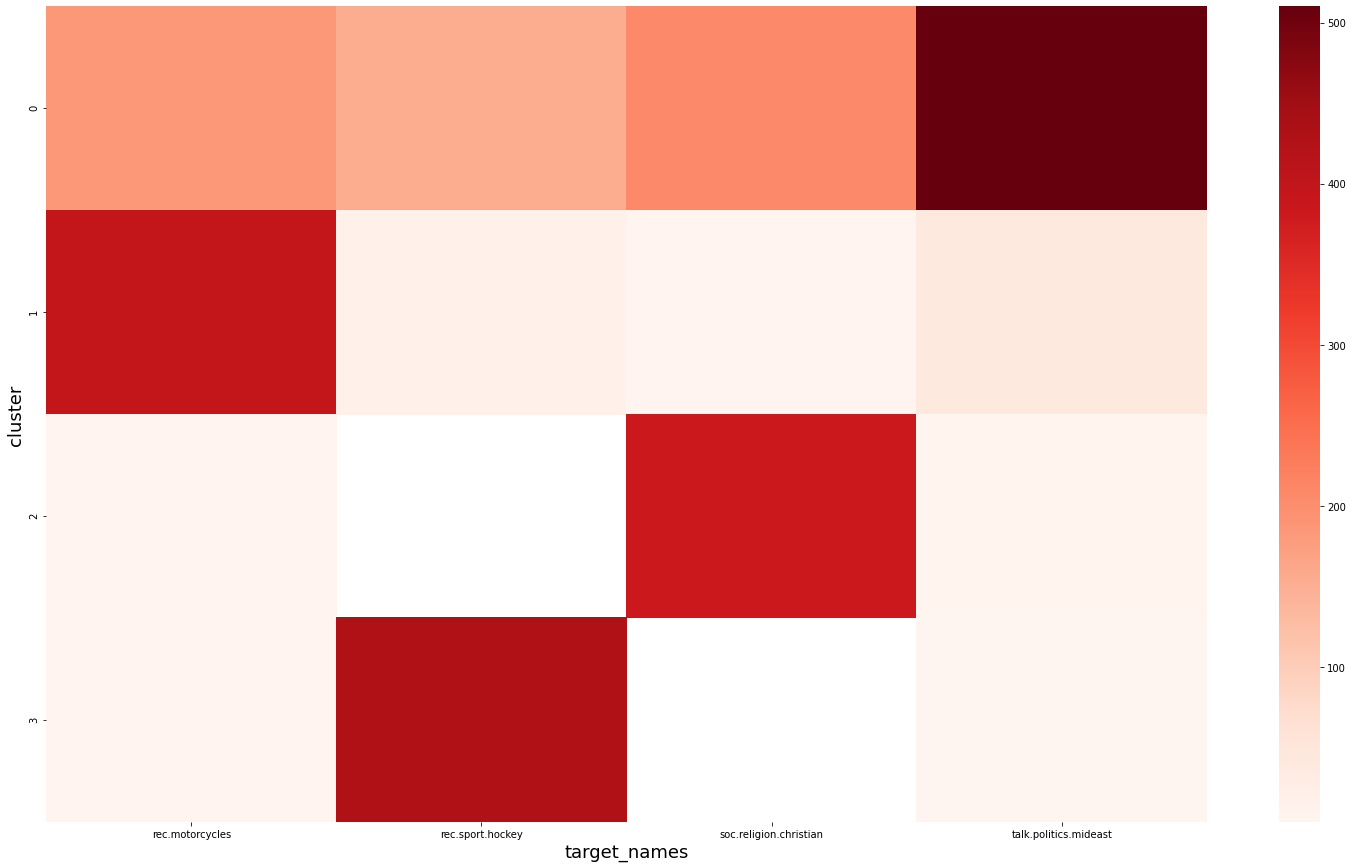

In [16]:
# Derive distribution
clusters = df.groupby(['cluster', 'target_names']).size()

# Generate plot
fig, ax1 = plt.subplots(figsize = (26, 15))
heatmap(clusters.unstack(level = 'target_names'), ax = ax1, cmap = 'Reds')

ax1.set_xlabel('target_names').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

This confirms the results from the top 10 words.

## Calculate performance

Here we will compare the predicted target (based on our analysis above) and the true target using a classification report.

In [17]:
df['pred'] = df['cluster'].apply(lambda x: 17 if x==0 else (8 if x==1 else (15 if x==2 else 10)))

In [18]:
print(classification_report(df['target'], df['pred']))

              precision    recall  f1-score   support

           8       0.86      0.67      0.75       598
          10       0.98      0.71      0.83       600
          15       0.96      0.64      0.77       599
          17       0.48      0.90      0.63       564

    accuracy                           0.73      2361
   macro avg       0.82      0.73      0.74      2361
weighted avg       0.82      0.73      0.74      2361



Overall accuracy is not bad considering we did a unsupervised training here. However, most classes have high precision and low recall while for 17 it is the other way round.

# 3. LDA Topic Modelling

In this section we will apply LDA topic modelling to the Newsgroups dataset.

In [19]:
# Create a Gensim dictionary from the preprocessed texts
texts= [text.split() for text in df['preprocessed']]
dictionary = corpora.Dictionary(texts)

# Remove rare and common words
dictionary.filter_extremes(no_below=118, no_above=0.95, keep_n=None)

# Derive absolute frequencies
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
# Run a LDA model
lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, chunksize=10, iterations=100, passes=10, random_state=42)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

* chunksize: how many documents are processed in one batch. If you don't have memory issues (not very probable) you can process all of them.
* iterations: number of times the LDA algorithm runs, should be high enough for convergence.
* passes: how many times do you pass through each chunk
* random_state: the LDA algorithm is not deterministic, so we need to set the random state for comparison

In [21]:
# Show top ten topics with their four most important words
lda.show_topics()

[(0,
  '0.045*"edu" + 0.040*"write" + 0.035*"articl" + 0.028*"com" + 0.023*"like" + 0.022*"israel" + 0.022*"apr" + 0.017*"time" + 0.017*"right" + 0.016*"isra"'),
 (1,
  '0.045*"god" + 0.028*"know" + 0.026*"peopl" + 0.023*"christian" + 0.022*"believ" + 0.019*"think" + 0.018*"reason" + 0.015*"evid" + 0.014*"jesu" + 0.013*"question"'),
 (2,
  '0.073*"team" + 0.052*"game" + 0.050*"hockei" + 0.037*"plai" + 0.032*"year" + 0.029*"win" + 0.029*"wing" + 0.026*"nhl" + 0.025*"player" + 0.024*"new"'),
 (3,
  '0.044*"peopl" + 0.044*"armenian" + 0.040*"turkish" + 0.039*"kill" + 0.034*"war" + 0.031*"govern" + 0.030*"public" + 0.026*"said" + 0.022*"state" + 0.020*"countri"')]

Topic 0 and 3 are about middle east, topic 1 about christianity and topic 2 about hockey. Motorcycles are not presented.

In [22]:
# Derive the topics for each document
topics=lda[corpus]

In [23]:
topics[0]

[(0, 0.94589984), (1, 0.018078538), (2, 0.018164247), (3, 0.017857393)]

In [24]:
# Add a column with the topics to the data frame
df['topics_lda']=[max(topics[i],key=lambda item:item[1])[0] for i in range(len(topics))]
df.head()

,content,target,target_names,preprocessed,cluster,pred,topics_lda
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,recommend duc worth ducati gt line ducati gt m...,1,8,0
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,nhl team captain articl apr samba oit unc edu ...,3,10,0
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,pantheism environment articl apr atho rutger e...,2,15,1
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,isra expans lust articl spam math adelaid edu ...,0,17,0
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,goali mask articl netnew upenn edu kkeller mai...,0,17,0


## Visualise results

In [25]:
# Use this visualisation to examine and compare different topics
# You can see as above that topic 2 and topic 3 are close to each other (both mideast politics)
pyLDAvis.enable_notebook()
LDAvis_prepared = prepare(lda, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.173193  0.260157       1        1  37.848044
1      0.018859 -0.069254       2        1  34.815197
2      0.162653 -0.215452       3        1  14.098988
3     -0.354705  0.024548       4        1  13.237772, topic_info=       Term         Freq        Total Category  logprob  loglift
28     team  1311.000000  1311.000000  Default  30.0000  30.0000
42      god  1974.000000  1974.000000  Default  29.0000  29.0000
198    game   936.000000   936.000000  Default  28.0000  28.0000
314  hockei   893.000000   893.000000  Default  27.0000  27.0000
53    peopl  2027.000000  2027.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
95     said   441.055246   908.519058   Topic4  -3.6414   1.2995
53    peopl   747.271783  2027.271130   Topic4  -3.1141   1.0241
141   state   365.213929   964.160225   Topic4  -3.8301   1.0513
115    year   296.741511  1233.445175   Topic4  -4.0377   0.5974
156   world   209.099744   623.584785   Topic4  -4.3878   0.9294

[199 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
32        2  0.996978  accept
69        1  0.997693  actual
128       1  0.997450    agre
157       2  0.996523  answer
12        1  0.968583     apr
...     ...       ...     ...
31        2  0.072097   write
31        3  0.047000   write
115       1  0.296730    year
115       3  0.462120    year
115       4  0.240789    year

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. where we define the relevance of a term to a topic, given a weight parameter, 0 ≤ λ ≤ 1, as λ log(p(term | topic)) + (1 - λ) log(p(term | topic)/p(term))